This notebook is to exemplify the obtention one of power law of a single treshold of the 2-point correlation function of enstrophy excursion sets. The objective is to provide an interactive enviroment to test different thresholds and provide a feel of what is the behavior of the system. 

In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

Following suit, it is necessary to import the libraries that are necessary to the work to be executed. These include  numpy for the generay array manipulations, pyFFTW to the Fourier Transforms, mpi4py for MPI support, general math, sys and os libraries and pyJHTDB, that provides a python wraper for the C-SOAP interface of the Johs Hopkins Turbulence Databases. We also import some modules that provide basic 3D FFT and histograming functionality build upon numpy and pyFFTW, as a way to streamline the overall process. Those modules, which include FFT3Dfield, IFFT3Dfield and EnergySpectrum, were originaly developed by Dr. Kun Yang.

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

We first initialize general domain constants, based on the isotropic1024coarse dictionary, which provide information on the isotropic turbulence database. We then initialize MPI variables, including the communicator, rank and number of process. The typical number of processes is 8, both because it doesn't, usually, overloads the sciserver hardware, but also it is the optimal number of processes to query the database. Afterwards, it is necessary to initalize the variables that designate the domain associated with each MPI process. Due to the way that the FFT3D modules were build, we chose to divide the domain in slabs split in the X direction. Also, constants related to wavenumber and chunck size downloads are initialized.

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

# Computational Domain

nx=Nx//nproc; ny=Ny; nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:3] 
n_proc = 8
rank = 0


Instead of downloading the velocity field from the website, we just load the cached value of enstrophy pre-computed from a previous notebook. On vm01 it takes between 60 to 90 seconds to load from disk. On vm04 is taking less than 6 seconds to load. 

In [4]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "ref-enstrophy-"+str(rank)+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:3] 
Finished loading
Load from disk: 4.62 seconds


We compute the global average of enstrophy. And also we compute minimum and maximum values of enstrophy, for reference.

In [ ]:
%%px

w2 = 0.5*w2

In [74]:
%%px

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("<w^2> : "+str(avgOmega))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("min w2/<w^2> : "+str(maxw2/avgOmega))

[stdout:3] 
<w^2> : 249.21774292
min w2/<w^2> : 1.43020472082e-07
min w2/<w^2> : 675.170126447


Here we need to alocate all arrays we need to do the calculations of the 2-point correlation function. Since there are many arrays to be alocated at the same time, it takes a fair amount of time. On vm01, it takes around 160 to 190 seconds. On vm04, is taking around 25 seconds to load, with some times running below 7 seconds.

In [6]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

comm.Barrier(); t1=MPI.Wtime()

X = np.zeros((nx,ny,nz), dtype='float32')
Y = np.zeros((nx,ny,nz), dtype='float32')
Z = np.zeros((nx,ny,nz), dtype='float32')
r2 = np.zeros((nx,ny,nz), dtype='float32')

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:3] Alocating vectors: 1.09 seconds


To properly arrange the real space radius to do the spherical integration, we need to assign the distance from the first coordinate, so we compute X, Y and Z arrays, with the respective coordinates, and from there we compute the distance squared to the origin. This is so because the relevant information is contained in the first octant, so all we need is to integrate spherically the first octant. This section takes a fair share of time, around 200-220 seconds. On vm04 is taking around 25 seconds. 

In [7]:
%%px

comm.Barrier(); t1=MPI.Wtime()
for i in range(nx):
    X[i,:,:] = (i+rank*nx)*isotropic1024coarse['dx']
    
for j in range(ny):
    Y[:,j,:] = j*isotropic1024coarse['dy']
    
for k in range(nz):
    Z[:,:,k] = k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

r2rt = np.sqrt(r2)
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

[stdout:3] Preparing the real domain for radial integration: 23.29 seconds


In [84]:
%%px
import copy

thresholds = [1,2,3,4,5,6,7,10,15,20,30,50]

tboxes = []

for t in thresholds:
    comm.Barrier(); t1=MPI.Wtime()
    
    Xs = X[w2 > t*avgOmega]
    Ys = Y[w2 > t*avgOmega]
    Zs = Z[w2 > t*avgOmega]
    
    print(Xs.shape)
    
    hist = np.zeros((Xs.shape[0],3))
    
    hist[:,0] = Xs[:]
    hist[:,1] = Ys[:]
    hist[:,2] = Zs[:]
    
    count = []
    scales = np.logspace(np.log(2*425*eta),np.log(0.1*42.5*eta), num=250, endpoint=True, base=np.e)
    #scales = [0.1*42.5*eta,0.3*42.5*eta]
    
    for L in scales:
        x1 = x0+isotropic1024coarse['lx']
        y1 = y0+isotropic1024coarse['ly']
        z1 = z0+isotropic1024coarse['lz']
        
        nx = int((x1-x0)/L)+1
        ny = int((y1-y0)/L)+1
        nz = int((z1-z0)/L)+1
        
        x1 = x0 + nx*L
        y1 = y0 + ny*L 
        z1 = z0 + nz*L
        
        H, edges = np.histogramdd(hist, bins=(nx,ny,nz), range=((x0,x1),(y0,y1),(z0,z1)), normed=True)
        
        Hglobal = np.zeros(H.shape,dtype='float64')
        comm.Allreduce([H,MPI.DOUBLE],[Hglobal,MPI.DOUBLE],op=MPI.SUM)
        
        Hn = Hglobal[:,:,:]
        Hn[Hn>0] = 1
        numBox = np.sum(Hn)
        gbox = np.zeros(1,dtype='float32')
        gbox[0] = numBox
        gbox = gbox[0]
        
        count.append(gbox)
    
    acount = np.array(count)
    
    tboxes.append(acount[:])
        
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Computing boxcounting numbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] 
1
(33005775,)
2
(16430167,)
3
(9922052,)
4
(6621584,)
5
(4708142,)
6
(3498437,)
7
(2685066,)
10
(1385182,)
15
(598802,)
20
(310927,)
30
(112317,)
50
(25284,)
[stdout:1] 
1
(28722589,)
2
(13818422,)
3
(8181744,)
4
(5378226,)
5
(3778065,)
6
(2777428,)
7
(2111742,)
10
(1067907,)
15
(450639,)
20
(229232,)
30
(79650,)
50
(18283,)
[stdout:2] 
1
(32554343,)
2
(16370935,)
3
(9998007,)
4
(6748599,)
5
(4848455,)
6
(3639074,)
7
(2820519,)
10
(1494103,)
15
(669505,)
20
(360252,)
30
(138072,)
50
(34880,)
[stdout:3] 
1
(34143109,)
Computing boxcounting numbers: 4045.79 seconds
2
(17683103,)
Computing boxcounting numbers: 2451.48 seconds
3
(11028482,)
Computing boxcounting numbers: 2164.60 seconds
4
(7563328,)
Computing boxcounting numbers: 1500.75 seconds
5
(5506944,)
Computing boxcounting numbers: 991.60 seconds
6
(4176759,)
Computing boxcounting numbers: 958.86 seconds
7
(3266027,)
Computing boxcounting numbers: 942.59 seconds
10
(1767217,)
Computing boxcounting numbers: 989.81 seconds

In [99]:
%%px 

if rank==0:
    print(tboxes[0])
    print(tboxes[1])
    tfboxes = np.array(tboxes)
    print(tfboxes)
    np.savez('boxcount-dims.npz',tfboxes = tfboxes)

[stdout:3] 
[  2.70000000e+01   2.70000000e+01   2.70000000e+01   2.70000000e+01
   2.70000000e+01   2.70000000e+01   2.70000000e+01   6.40000000e+01
   6.40000000e+01   6.40000000e+01   6.40000000e+01   6.40000000e+01
   6.40000000e+01   6.40000000e+01   6.40000000e+01   6.40000000e+01
   6.40000000e+01   6.40000000e+01   6.40000000e+01   6.40000000e+01
   1.25000000e+02   1.25000000e+02   1.25000000e+02   1.25000000e+02
   1.25000000e+02   1.25000000e+02   1.25000000e+02   1.25000000e+02
   1.25000000e+02   1.25000000e+02   1.25000000e+02   2.16000000e+02
   2.16000000e+02   2.16000000e+02   2.16000000e+02   2.16000000e+02
   2.16000000e+02   2.16000000e+02   2.16000000e+02   3.43000000e+02
   3.43000000e+02   3.43000000e+02   3.43000000e+02   3.43000000e+02
   3.43000000e+02   3.43000000e+02   5.12000000e+02   5.12000000e+02
   5.12000000e+02   5.12000000e+02   5.12000000e+02   5.12000000e+02
   5.12000000e+02   7.29000000e+02   7.29000000e+02   7.29000000e+02
   7.29000000e+02   7.

[output:3]

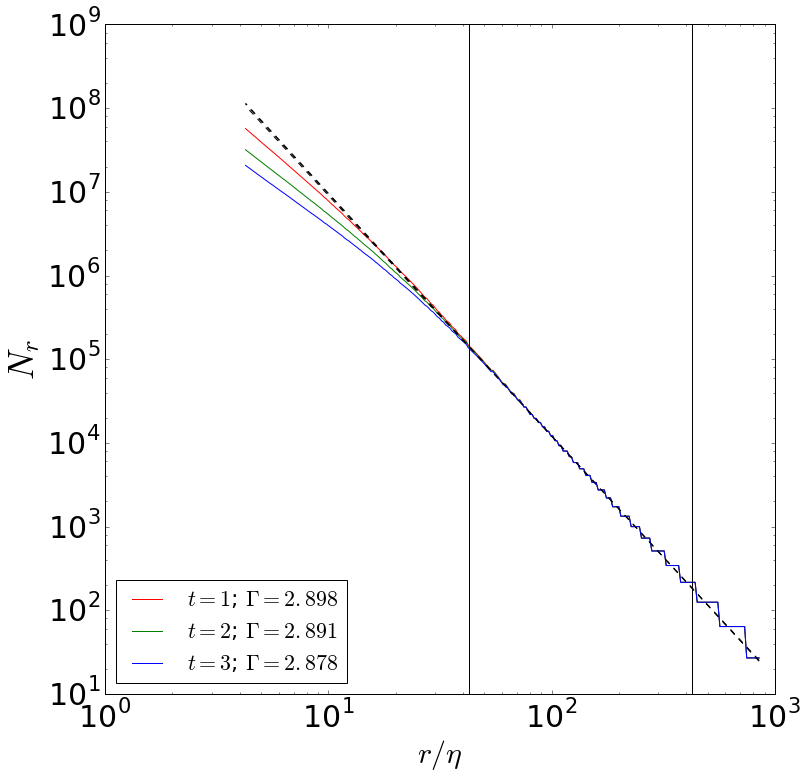

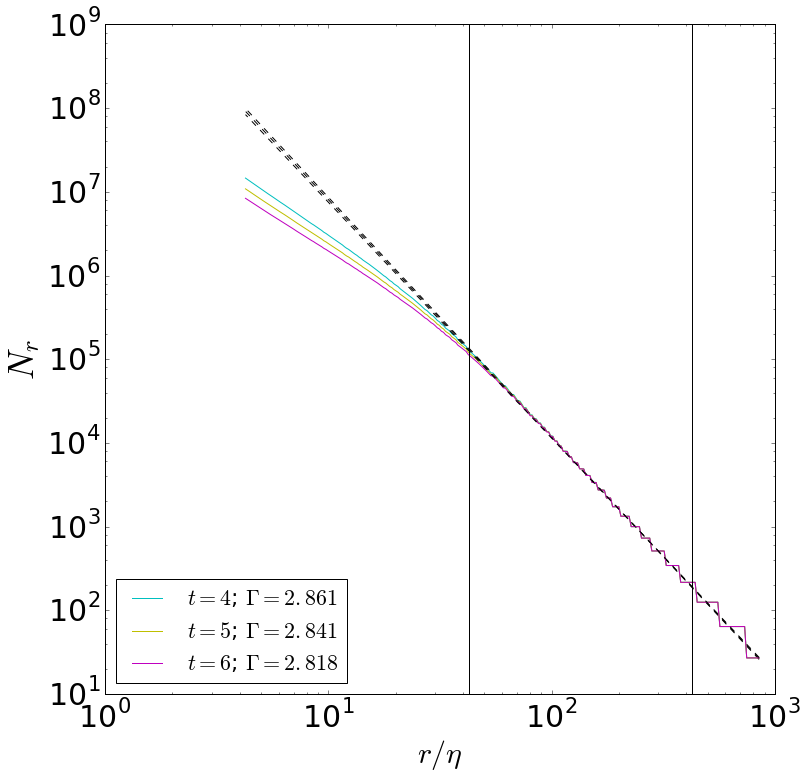

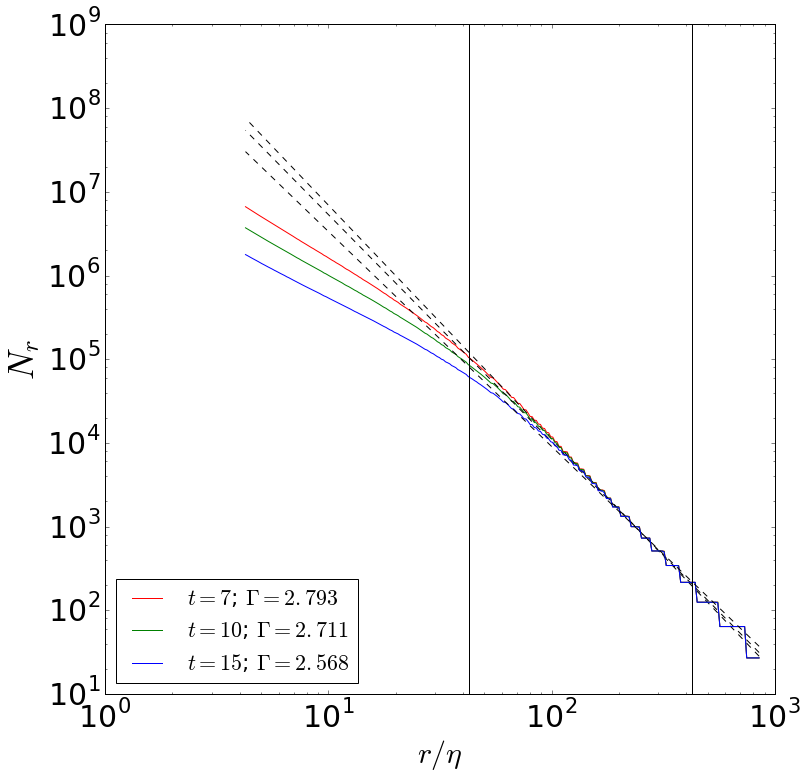

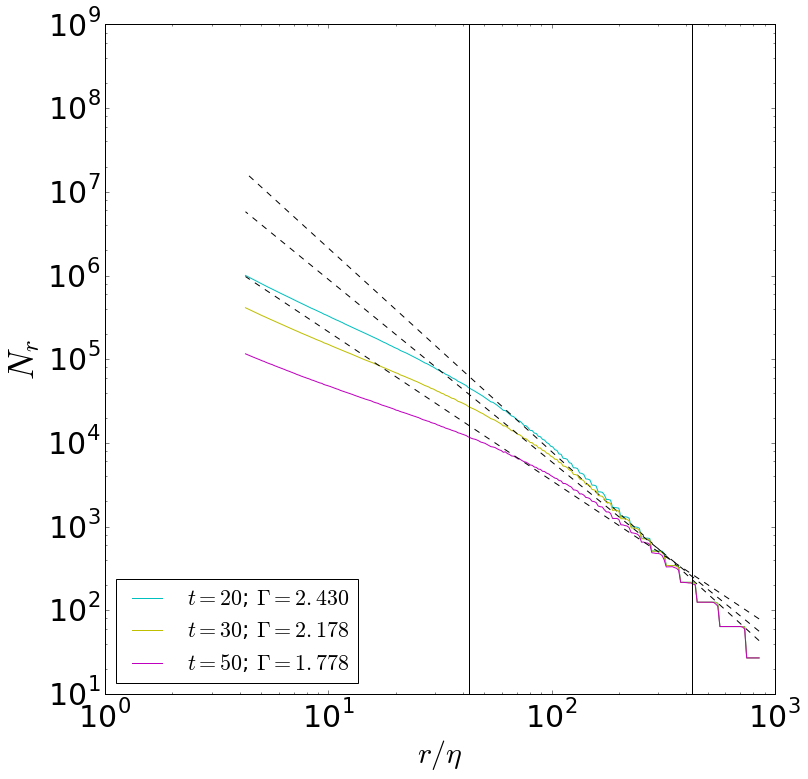

In [101]:
%%px
%matplotlib inline

eta = 0.00280

thresholds = [1,2,3,4,5,6,7,10,15,20,30,50]
colors = ['r','g','b','c','y','m','r','g','b','c','y','m']

if(rank==0):
    fig = plt.figure(figsize=(12,12))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)      
    plt.xlabel(r'$r/\eta$',size=30)
    plt.ylabel(r'$N_r$',size=35)
    plt.ylim([10**1,10**3])
    plt.ylim([10**1,10**9])
    #plt.title(r'$t=5\langle \omega^2 \rangle;\ D_{box} = '+str(-fit[0])+r'$',size=20)
    
    idx = (scales>42.5*eta)&(scales<425*eta)
    
    for i in range(0,3,1):
        t = thresholds[i]
        c = colors[i]
        
        ct = np.array(tboxes[i])
        
        fit = np.polyfit(np.log(scales[idx]),np.log(ct[idx]),1)
        
        plt.loglog(scales/eta,ct,c+'-',label=r'$t = {:6.0f}$; $\Gamma = {:6.3f}$'.format(t,-fit[0]))
        plt.loglog(scales/eta,np.exp(fit[1])*(scales**(fit[0])),'k--')
    
    plt.axvline(x=42.5,color='k')
    plt.axvline(x=425.,color='k')
    plt.legend(loc='lower left',prop={'size':22})
    plt.savefig('boxcounting-dim-1-3.pdf')
    
    fig = plt.figure(figsize=(12,12))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)      
    plt.xlabel(r'$r/\eta$',size=30)
    plt.ylabel(r'$N_r$',size=35)
    plt.ylim([10**1,10**3])
    plt.ylim([10**1,10**9])
    for i in range(3,6,1):
        t = thresholds[i]
        c = colors[i]
        
        ct = np.array(tboxes[i])
        
        fit = np.polyfit(np.log(scales[idx]),np.log(ct[idx]),1)
        
        plt.loglog(scales/eta,ct,c+'-',label=r'$t = {:6.0f}$; $\Gamma = {:6.3f}$'.format(t,-fit[0]))
        plt.loglog(scales/eta,np.exp(fit[1])*(scales**(fit[0])),'k--')
    
    plt.axvline(x=42.5,color='k')
    plt.axvline(x=425.,color='k')
    plt.legend(loc='lower left',prop={'size':22})
    plt.savefig('boxcounting-dim-4-6.pdf')
    
    fig = plt.figure(figsize=(12,12))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)      
    plt.xlabel(r'$r/\eta$',size=30)
    plt.ylabel(r'$N_r$',size=35)
    plt.ylim([10**1,10**3])
    plt.ylim([10**1,10**9])
    #for i in range(6,12,1):
    for i in range(6,9,1):
        t = thresholds[i]
        c = colors[i]
        
        ct = np.array(tboxes[i])
        
        fit = np.polyfit(np.log(scales[idx]),np.log(ct[idx]),1)
        
        plt.loglog(scales/eta,ct,c+'-',label=r'$t = {:6.0f}$; $\Gamma = {:6.3f}$'.format(t,-fit[0]))
        plt.loglog(scales/eta,np.exp(fit[1])*(scales**(fit[0])),'k--')
    
    plt.axvline(x=42.5,color='k')
    plt.axvline(x=425.,color='k')
    plt.legend(loc='lower left',prop={'size':22})
    plt.savefig('boxcounting-dim-7-15.pdf')
    
    fig = plt.figure(figsize=(12,12))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)      
    plt.xlabel(r'$r/\eta$',size=30)
    plt.ylabel(r'$N_r$',size=35)
    plt.ylim([10**1,10**3])
    plt.ylim([10**1,10**9])
    #for i in range(6,12,1):
    for i in range(9,12,1):
        t = thresholds[i]
        c = colors[i]
        
        ct = np.array(tboxes[i])
        
        fit = np.polyfit(np.log(scales[idx]),np.log(ct[idx]),1)
        
        plt.loglog(scales/eta,ct,c+'-',label=r'$t = {:6.0f}$; $\Gamma = {:6.3f}$'.format(t,-fit[0]))
        plt.loglog(scales/eta,np.exp(fit[1])*(scales**(fit[0])),'k--')
    
    plt.axvline(x=42.5,color='k')
    plt.axvline(x=425.,color='k')
    plt.legend(loc='lower left',prop={'size':22})
    plt.savefig('boxcounting-dim-20-50.pdf')